# 尝试在乔哥的图片上找到黑白两色的颗粒

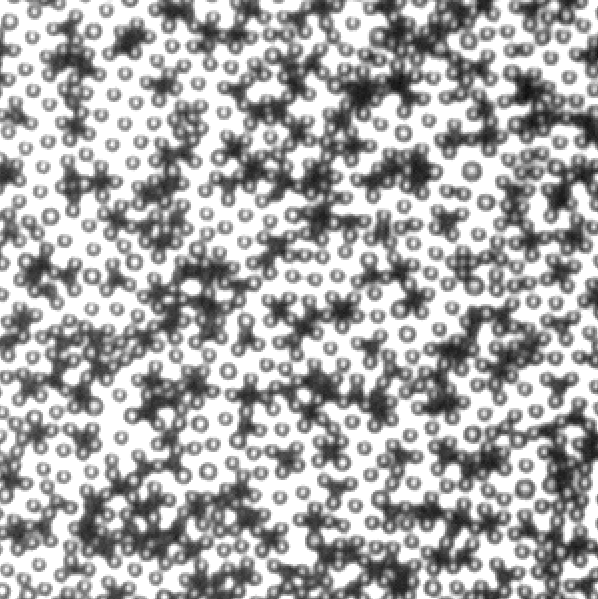

首先试了试ImageJ的Trackmate插件，用LoG方法（7 pixel，threshold 10）可以得到如下效果。这个方法两色的颗粒都能找到一些，但黑色颗粒位置相对准确，白色颗粒位置有些偏，原因是这个方法是在图片里找类似gaussian的峰，所以白色的颗粒的边缘会被当做中心。所以我们可以基于这个方法的结果，挑选出黑色颗粒，即在下图中亮度总和高的区域。白色区域则用一个类似Mexican hat的图案重新找出。

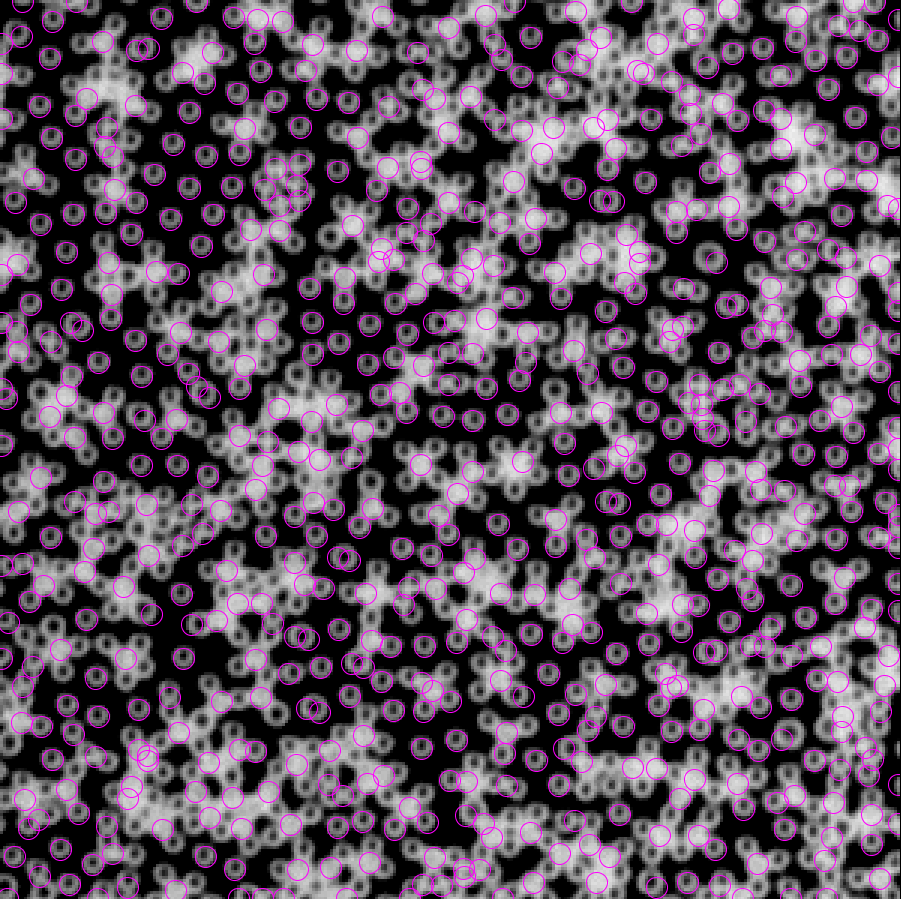

这里用Python代码实现TrackMate的LoG方法（非完全复现，没有细节，只有基本思路）。

In [7]:
from skimage import io
import matplotlib.pyplot as plt

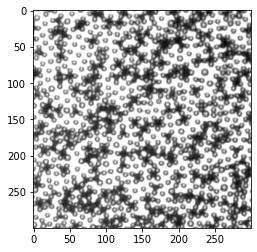

In [5]:
img = io.imread("try0000_imj.tif")
plt.imshow(img, cmap="gray")

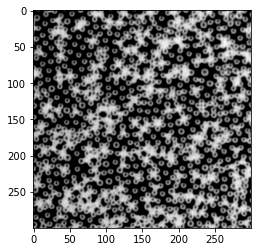

In [6]:
# invert image
inv_img = 255 - img
plt.imshow(inv_img, cmap="gray")

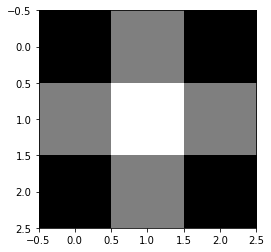

In [62]:
# generate a gaussian mask 
from myImageLib import matlab_style_gauss2D
# matlab_style_gauss2D(shape=(3,3),sigma=0.5)
gauss_mask = matlab_style_gauss2D(shape=(3,3),sigma=7)
plt.imshow(gauss_mask, cmap="gray")

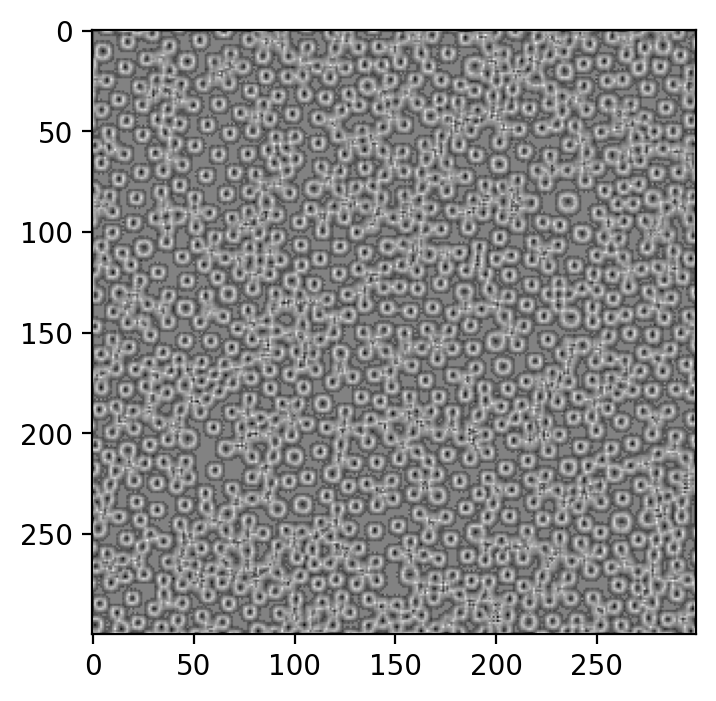

In [63]:
# compute correlation map between inv_img and gauss_mask
from xcorr_funcs import normxcorr2
corr = normxcorr2(gauss_mask, inv_img, "same")
plt.figure(dpi=200)
plt.imshow(corr, cmap="gray")

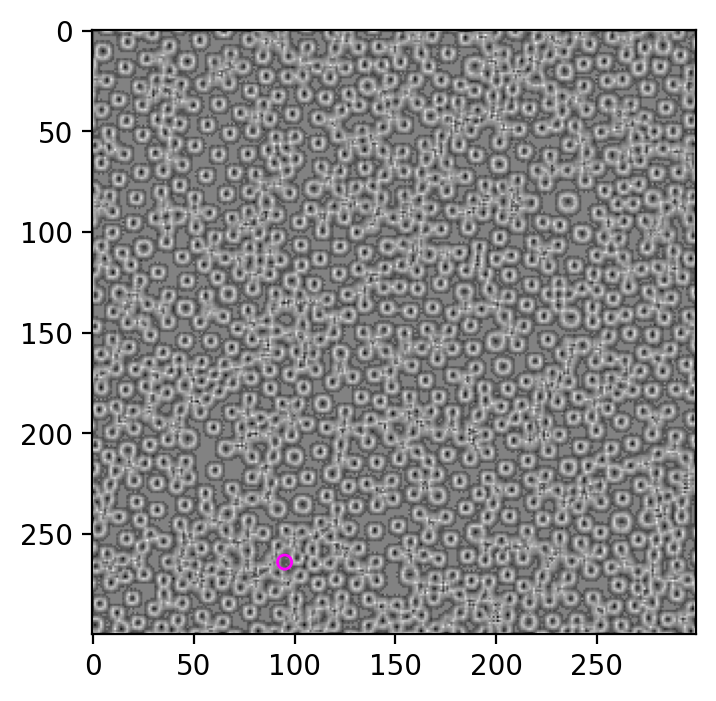

In [73]:
# find peaks on the correlation map corr
from xcorr_funcs import FastPeakFind
from matplotlib.patches import Circle
peak = FastPeakFind(-corr)
fig, ax = plt.subplots(dpi=200)
ax.imshow(corr, cmap="gray")
for x, y in peak.T:
    circ = Circle((y, x), radius=3.5, ec="magenta", fill=False)
    ax.add_patch(circ)

In [74]:
peak

array([[264],
       [ 95]], dtype=int64)

In [65]:
peak.shape

(2, 1)

In [70]:
def FastPeakFind(data):
    if str(data.dtype) != 'float32':
        data = data.astype('float32')
   
    mf = medfilt2d(data, kernel_size=3)
    mf = mf.astype('float32')

    thres = max(min(np.amax(mf,axis=0)), min(np.amax(mf,axis=1)))
    
    filt = matlab_style_gauss2D()
    conv = convolve2d(mf, filt, mode='same')
    w_idx = conv > thres
    bw = conv.copy()
    bw[w_idx] = 1
    bw[~w_idx] = 0
    thresholded = np.multiply(bw, conv)

    
    edg = 3
    shape = data.shape
    idx = np.nonzero(thresholded[edg-1: shape[0]-edg-1, edg-1: shape[1]-edg-1])
    idx = np.transpose(idx)
    
    
    cent = []
    for xy in idx:
        x = xy[0]
        y = xy[1]
        if thresholded[x, y] >= thresholded[x-1, y-1] and \
            thresholded[x, y] >= thresholded[x-1, y] and \
            thresholded[x, y] >= thresholded[x-1, y+1] and \
            thresholded[x, y] >= thresholded[x, y-1] and \
            thresholded[x, y] >= thresholded[x, y+1] and \
            thresholded[x, y] >= thresholded[x+1, y-1] and \
            thresholded[x, y] >= thresholded[x+1, y] and \
            thresholded[x, y] >= thresholded[x+1, y+1]:
            cent.append(xy)
    # for xy in cent:
        # y = xy[0]
        # x = xy[1]
        # plt.plot(x, y, 'ro', markersize=3)
    # plt.show()
    cent = np.asarray(cent)
    return cent

显然我对LoG方法的理解有些问题，明天多读读文档想想如何解决。